# Word-level entropy and Z-score analysis

## Table of content (ToC)<a class="anchor" id="TOC"></a> *nog aanpassen*

* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Setting up the environment</a>
  * <a href="#bullet2x1">2.1 - Load TF code</a>
  * <a href="#bullet2x2">2.2 - Load TF </a>
  * <a href="#bullet2x3">2.3 - Define the OSIS IS lookup table</a>
* <a href="#bullet3">3 - Create the additonal TF features</a>    
  * <a href="#bullet3x1">3.1 - Prepare metadata</a>
  * <a href="#bullet3x2">3.2 - Prepare featuredata</a>
  * <a href="#bullet3x3">3.3 - Link featuredata to metadata</a>
  * <a href="#bullet3x4">3.4 - Save the features to file</a>
  * <a href="#bullet3x5">3.5 - Save the newly created features</a>
* <a href="#bullet4">4 - Notebook version</a>

# 1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This notebook analyzes the predictive impact of each word's surface text, lemma, and morphological tag on the phrase function it belongs to, using entropy and normalized Z-scores.

# Setting up the environment <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

## 2.1 - Load additional Python packages <a class="anchor" id="bullet2x1"></a>

The following packages are needed to perform the statistical calculations.

In [64]:
import pandas as pd
import numpy as np

## 2.2 - Load TF with N1904-TF and the N1904addons <a class="anchor" id="bullet2x2"></a>

For this calculations we also do need the N1904additons dataset.

In [65]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from tf.fabric import Fabric
from tf.app import use

In [67]:
# load the N1904 app and data
N1904 = use ("CenterBLC/N1904", version="1.0.0", mod="tonyjurg/N1904addons/tf/", silence="terse", hoist=globals() )

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

# Create the input data

In this section we will obtain the relevant data per wordnode that would allow for the calculation of z-value

In [68]:
import pandas as pd
import logging
from tqdm.std import tqdm

import common 
"""
    Here I load the functions defined in 'common.py':
    
       - find_parent(wordNode, F, L): Return (parent_node, subflag), or (None, None) if no phrase or subphrase found.
       - find_role(wordNode, F, L): Attempt to find the role on the word itself, then fallback up the wg-chain.
       - determine_pf(parent_node, morph, pos, lemma, role, F, L): Determine the phrase-function with overrides.
       
   Note that we need to pass Text-Fabric’s global namespace for node features (F) and locality (L)
   
   usage: 
        common.find_parent(wordNode,L)
"""

# ——— main processing loop ———
rows = []

for wordNode in tqdm(F.otype.s("word"), desc="Processing word nodes"):
    # Retrieve basic features
    morph = F.morph.v(wordNode)
    text  = F.text.v(wordNode)
    lemma = F.lemma.v(wordNode)
    pos   = F.sp.v(wordNode)
    text_entr = F.text_entr.v(wordNode)
    lemma_entr = F.lemma_entr.v(wordNode)
    morph_entr = F.morph_entr.v(wordNode)
    
    

    # Find the parent node and whether it is a subphrase
    parent_node, subflag = common.find_parent(wordNode, F, L)
    if parent_node is None:
        print('stuf')
        logging.warning(
            f"No phrase or subphrase found for word {wordNode} at "
            f"{T.sectionFromNode(wordNode)} (text={text}, pos={pos})"
        )
        continue

    # Determine the role of the word
    role = common.find_role(wordNode, F, L)

    # Determine the phrase-function for each word
    pf = common.determine_pf(parent_node, morph, pos, lemma, role, F, L) or f'None'

    # Compile the row and add to the output list
    row = {
        "word_id"         : wordNode,
        "text"            : text,
        "morph"           : morph,
        # Since in TF the entropy values are stored as string, we need to convert them to floats
        "text_entr"       : float(text_entr),
        "lemma_entr"      : float(lemma_entr),
        "morph_entr"      : float(morph_entr),
        "lemma"           : lemma,
        "role"            : role,
        "phrase_function" : pf,
        "parent_node"     : parent_node, # for analytic & debug reasons
    }
    rows.append(row)

# Convert the collected rows into a DataFrame
df = pd.DataFrame(rows)

Processing word nodes: 100%|██████████| 137779/137779 [00:02<00:00, 65360.69it/s]


In [69]:
df.head()

,word_id,text,morph,text_entr,lemma_entr,morph_entr,lemma,role,phrase_function,parent_node
0,1,Βίβλος,N-NSF,0.000000,1.156779,0.817138,βίβλος,p,PreC,189518
1,2,γενέσεως,N-GSF,0.918295,1.921928,1.736995,γένεσις,p,PreC,189518
2,3,Ἰησοῦ,N-GSM,1.725752,1.695757,1.909936,Ἰησοῦς,p,PreC,189518
3,4,Χριστοῦ,N-GSM,1.783890,1.993981,1.909936,Χριστός,p,PreC,189518
4,5,υἱοῦ,N-GSM,1.000000,2.160394,1.909936,υἱός,apposition,PreC,189518


### Compute Z-Scores for Entropy Columns

A Z-score (or standard score) is a normalized value that tells how far a data point is from the mean, in terms of standard deviations (definiton+):

$$
Z = \frac{x - \mu}{\sigma} \tag{1}
$$

Where:

* $x$ is the original value,
* $\mu$ is the mean of the dataset,
* $\sigma$ is the standard deviation.


In [70]:
# Z-scores for entropy per layer
df['z_text'] = (df['text_entr'] - df['text_entr'].mean()) / df['text_entr'].std()
df['z_lemma'] = (df['lemma_entr'] - df['lemma_entr'].mean()) / df['lemma_entr'].std()
df['z_morph'] = (df['morph_entr'] - df['morph_entr'].mean()) / df['morph_entr'].std()
df.sort_values(by='z_morph', ascending=False)

,word_id,text,morph,text_entr,lemma_entr,morph_entr,lemma,role,phrase_function,parent_node,z_text,z_lemma,z_morph
82855,82856,οὔτε,CONJ-N,2.430056,2.439752,2.727135,οὔτε,o,Objc,233248,2.488191,1.578878,2.708627
9349,9350,οὐδὲ,CONJ-N,2.538548,2.479345,2.727135,οὐδέ,o,Objc,194317,2.643617,1.625145,2.708627
127401,127402,οὔτε,CONJ-N,2.430056,2.439752,2.727135,οὔτε,None,Unkn,372016,2.488191,1.578878,2.708627
129403,129404,οὔτε,CONJ-N,2.430056,2.439752,2.727135,οὔτε,p,PreC,255233,2.488191,1.578878,2.708627
82863,82864,οὔτε,CONJ-N,2.430056,2.439752,2.727135,οὔτε,o,Objc,233248,2.488191,1.578878,2.708627
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24613,24614,δὲ,CONJ,0.000000,0.000000,0.000000,δέ,None,Conj,286073,-0.993117,-1.272104,-1.403865
24617,24618,καὶ,CONJ,0.000000,0.000000,0.000000,καί,o2,Conj,202424,-0.993117,-1.272104,-1.403865
137676,137677,καὶ,CONJ,0.000000,0.000000,0.000000,καί,s,Conj,258482,-0.993117,-1.272104,-1.403865
137681,137682,καὶ,CONJ,0.000000,0.000000,0.000000,καί,None,Conj,382612,-0.993117,-1.272104,-1.403865


In [71]:
df.sort_values(by='z_text', ascending=False)

,word_id,text,morph,text_entr,lemma_entr,morph_entr,lemma,role,phrase_function,parent_node,z_text,z_lemma,z_morph
30395,30396,ἀγαθῶν,A-GPM,2.584962,2.179531,1.834383,ἀγαθός,adv,Adv,205534,2.710110,1.274796,1.362366
112043,112044,ἀγαθῶν,A-GPN,2.584962,2.179531,1.628340,ἀγαθός,apposition,Cmpl,246924,2.710110,1.274796,1.051655
118350,118351,ἀγαθῶν,A-GPN,2.584962,2.179531,1.628340,ἀγαθός,o,Objc,249888,2.710110,1.274796,1.051655
118016,118017,ἀγαθῶν,A-GPN,2.584962,2.179531,1.628340,ἀγαθός,apposition,Subj,249745,2.710110,1.274796,1.051655
70688,70689,ἀγαθῶν,A-GPN,2.584962,2.179531,1.628340,ἀγαθός,adv,Unkn,321838,2.710110,1.274796,1.051655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19775,19776,ἐπέθηκεν,V-AAI-3S,0.000000,0.000000,0.017383,ἐπιτίθημι,v,Pred,199827,-0.993117,-1.272104,-1.377651
19778,19779,Σίμωνι,N-DSM,0.000000,2.115424,1.333587,Σίμων,io,Cmpl,199829,-0.993117,1.199883,0.607171
19780,19781,καὶ,CONJ,0.000000,0.000000,0.000000,καί,None,Conj,282452,-0.993117,-1.272104,-1.403865
137696,137697,Μαρτυρῶ,V-PAI-1S,0.000000,0.000000,0.691631,μαρτυρέω,v,Pred,258494,-0.993117,-1.272104,-0.360892


## Plotting it 

Figuring out which plot is the most explainatory

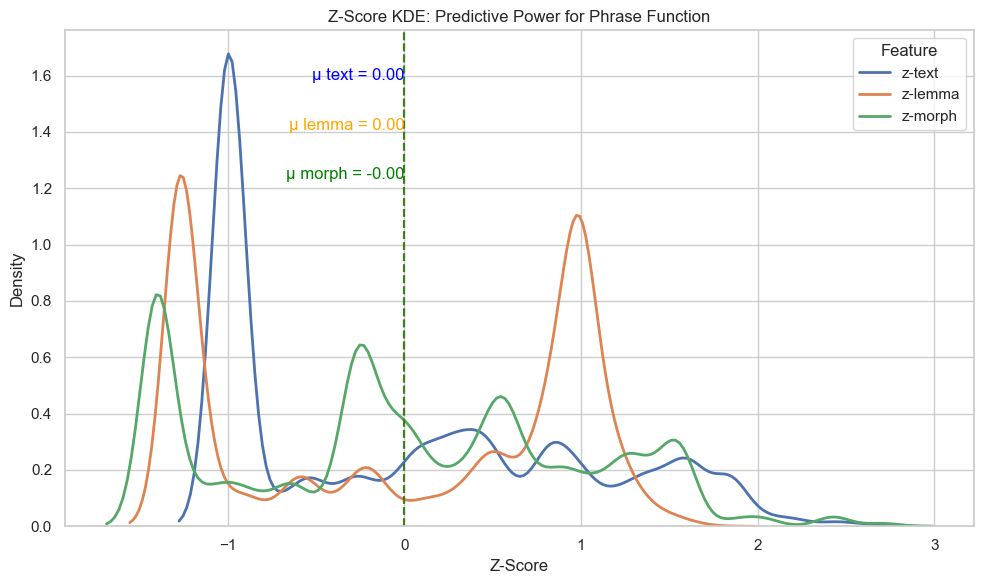

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot KDE curves for each feature
sns.kdeplot(df['z_text'], label='z-text', linewidth=2)
sns.kdeplot(df['z_lemma'], label='z-lemma', linewidth=2)
sns.kdeplot(df['z_morph'], label='z-morph', linewidth=2)

# Compute and annotate means
mean_text = df['z_text'].mean()
mean_lemma = df['z_lemma'].mean()
mean_morph = df['z_morph'].mean()

plt.axvline(mean_text, color='blue', linestyle='--', alpha=0.7)
plt.axvline(mean_lemma, color='orange', linestyle='--', alpha=0.7)
plt.axvline(mean_morph, color='green', linestyle='--', alpha=0.7)

plt.text(mean_text, plt.ylim()[1]*0.9, f"μ text = {mean_text:.2f}", color='blue', ha='right')
plt.text(mean_lemma, plt.ylim()[1]*0.8, f"μ lemma = {mean_lemma:.2f}", color='orange', ha='right')
plt.text(mean_morph, plt.ylim()[1]*0.7, f"μ morph = {mean_morph:.2f}", color='green', ha='right')

# Titles and labels
plt.title("Z-Score KDE: Predictive Power for Phrase Function")
plt.xlabel("Z-Score")
plt.ylabel("Density")
plt.legend(title="Feature")
plt.tight_layout()
plt.show()


It is actualy no surprise μ = 0 for all cases (has to do with the definitions...)

## Other plotting attempt

# now per unique wordform, lemma and morph

In [72]:
word_entropy = df.groupby('text')['text_entr'].mean().reset_index(name='avg_entropy')
lemma_entropy = df.groupby('lemma')['lemma_entr'].mean().reset_index(name='avg_entropy')
morph_entropy = df.groupby('morph')['morph_entr'].mean().reset_index(name='avg_entropy')



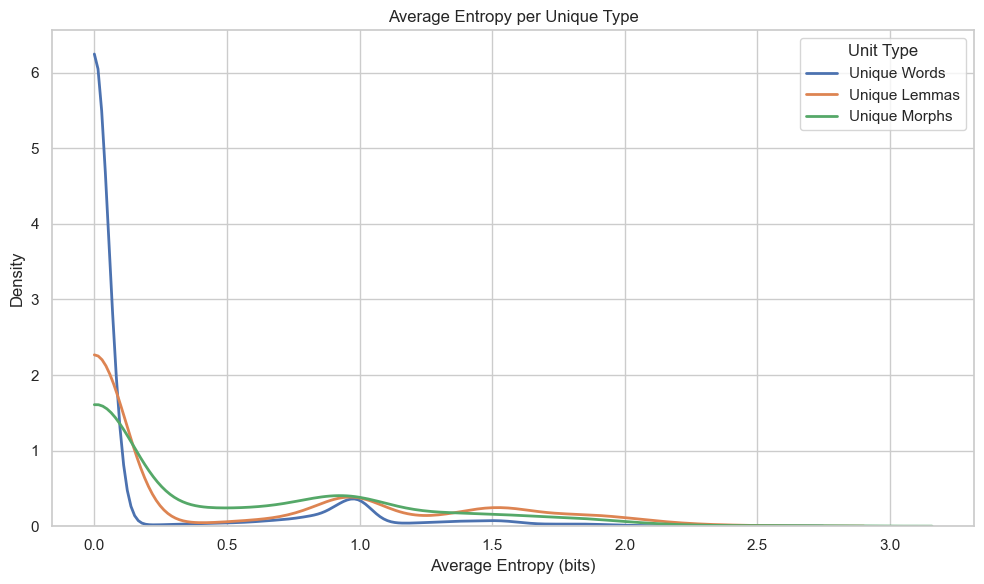

In [73]:
plt.figure(figsize=(10, 6))

sns.kdeplot(word_entropy['avg_entropy'], label='Unique Words', linewidth=2, clip=(0, None))
sns.kdeplot(lemma_entropy['avg_entropy'], label='Unique Lemmas', linewidth=2, clip=(0, None))
sns.kdeplot(morph_entropy['avg_entropy'], label='Unique Morphs', linewidth=2, clip=(0, None))

plt.title("Average Entropy per Unique Type")
plt.xlabel("Average Entropy (bits)")
plt.ylabel("Density")
plt.legend(title="Unit Type")
plt.grid(True)
plt.tight_layout()
plt.show()


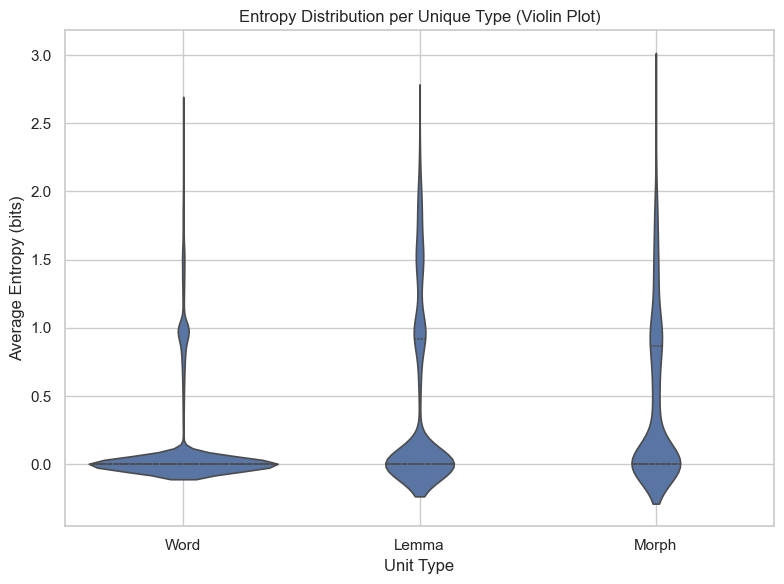

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare a long-format DataFrame for Seaborn
word_entropy['type'] = 'Word'
lemma_entropy['type'] = 'Lemma'
morph_entropy['type'] = 'Morph'

combined_df = pd.concat([word_entropy, lemma_entropy, morph_entropy], ignore_index=True)

# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=combined_df, x='type', y='avg_entropy', inner='quartile', linewidth=1.2)

# Labeling
plt.title("Entropy Distribution per Unique Type (Violin Plot)")
plt.xlabel("Unit Type")
plt.ylabel("Average Entropy (bits)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='type', ylabel='avg_entropy'>

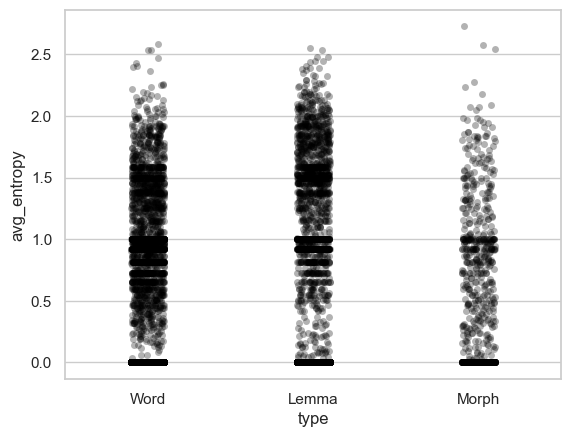

In [40]:
#sns.boxplot(data=combined_df, x='type', y='avg_entropy')
sns.stripplot(data=combined_df, x='type', y='avg_entropy', color='black', alpha=0.3)


C:\Users\tonyj\AppData\Local\Temp\ipykernel_17660\1496503412.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


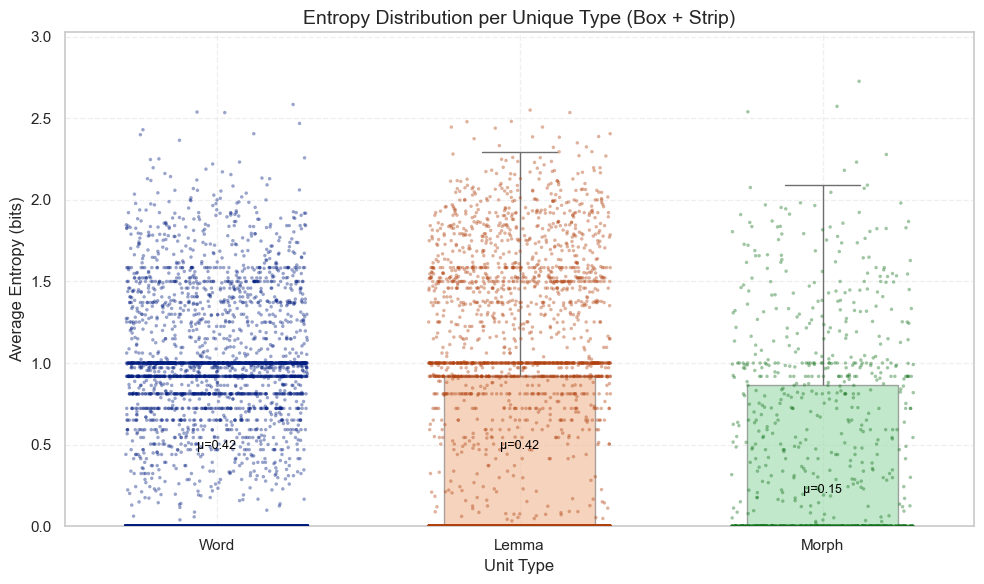

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare combined DataFrame if not already done
word_entropy['type'] = 'Word'
lemma_entropy['type'] = 'Lemma'
morph_entropy['type'] = 'Morph'
combined_df = pd.concat([word_entropy, lemma_entropy, morph_entropy], ignore_index=True)

# Create figure and axis
plt.figure(figsize=(10, 6))

# Underlay a boxplot to show quartiles and outliers
sns.boxplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    width=0.5,
    palette='pastel',
    fliersize=0,  # hide outlier markers
    boxprops=dict(alpha=0.6)
)

sns.stripplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    hue='type',
    palette='dark',
    dodge=False,
    jitter=0.3,
    size=2.5,
    alpha=0.4,
    linewidth=0
)

means = combined_df.groupby('type')['avg_entropy'].mean()
for i, (label, mean_val) in enumerate(means.items()):
    plt.text(i, mean_val + 0.05, f"μ={mean_val:.2f}", ha='center', color='black', fontsize=9)

# Labels and layout
plt.title("Entropy Distribution per Unique Type (Box + Strip)", fontsize=14)
plt.xlabel("Unit Type", fontsize=12)
plt.ylabel("Average Entropy (bits)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.3)
plt.ylim(0, combined_df['avg_entropy'].max() + 0.3)
plt.show()



C:\Users\tonyj\AppData\Local\Temp\ipykernel_17660\1805447040.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


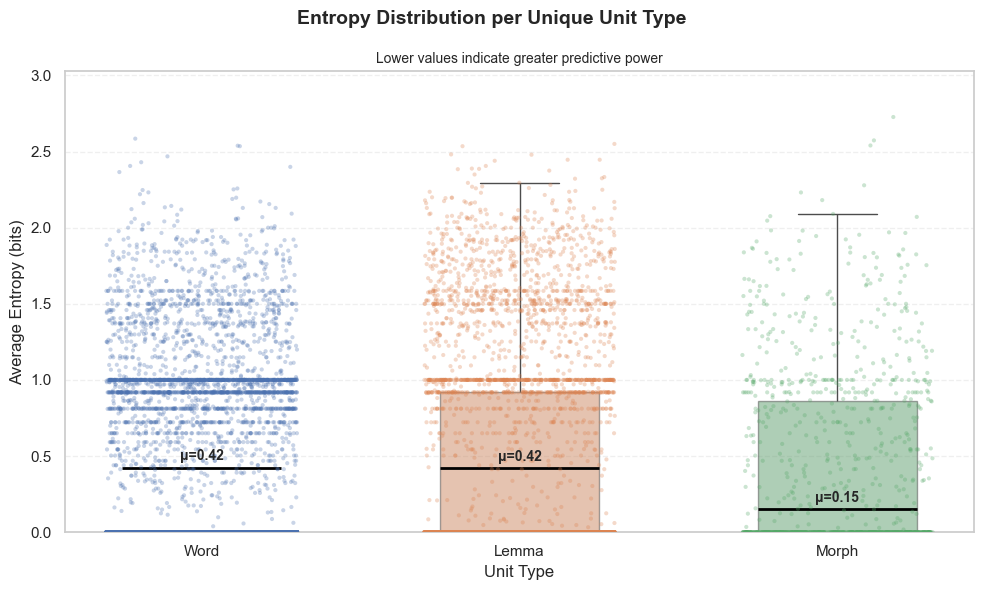

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare combined DataFrame if not already done
word_entropy['type'] = 'Word'
lemma_entropy['type'] = 'Lemma'
morph_entropy['type'] = 'Morph'
combined_df = pd.concat([word_entropy, lemma_entropy, morph_entropy], ignore_index=True)

# Calculate means for annotation
means = combined_df.groupby('type')['avg_entropy'].mean()

# Set style
sns.set(style="whitegrid")

# Define custom palette
palette = {
    'Word': '#4C72B0',   # blue
    'Lemma': '#DD8452',  # orange
    'Morph': '#55A868'   # green
}

# Create the plot
plt.figure(figsize=(10, 6))

# Boxplot (muted, no outlier dots)
sns.boxplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    palette=palette,
    width=0.5,
    fliersize=0,
    boxprops=dict(alpha=0.5)
)

# Stripplot (jittered points for density)
sns.stripplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    hue='type',
    palette=palette,
    dodge=False,
    jitter=0.3,
    size=3,
    alpha=0.3,
    linewidth=0
)

# Plot horizontal mean lines + label
for i, (label, mean_val) in enumerate(means.items()):
    plt.hlines(mean_val, i - 0.25, i + 0.25, color='black', linewidth=2)
    plt.text(i, mean_val + 0.05, f"μ={mean_val:.2f}", ha='center', fontsize=10, weight='bold')

# Improve layout
plt.suptitle("Entropy Distribution per Unique Unit Type", fontsize=14, fontweight='bold')
plt.title("Lower values indicate greater predictive power", fontsize=10)
plt.xlabel("Unit Type", fontsize=12)
plt.ylabel("Average Entropy (bits)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, combined_df['avg_entropy'].max() + 0.3)
plt.legend([],[], frameon=False)  # hide redundant legend from stripplot
plt.tight_layout()
plt.show()


### Checking the interquartile range (IQR)

In [47]:
print(combined_df[combined_df['type'] == 'Word']['avg_entropy'].describe())

count    19446.000000
mean         0.150982
std          0.393071
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.584962
Name: avg_entropy, dtype: float64


In [49]:
print(combined_df[combined_df['type'] == 'Morph']['avg_entropy'].describe())

count    1055.000000
mean        0.420148
std         0.579520
min         0.000000
25%         0.000000
50%         0.000000
75%         0.864716
max         2.727135
Name: avg_entropy, dtype: float64


In [50]:
print(combined_df[combined_df['type'] == 'Lemma']['avg_entropy'].describe())

count    5396.000000
mean        0.423607
std         0.654562
min         0.000000
25%         0.000000
50%         0.000000
75%         0.918295
max         2.550340
Name: avg_entropy, dtype: float64


This means that for type=word all tree percentiles (25%, 50% and 75%)  have zero entropy! Hence Seaborn’s boxplot collapses the box into a line at y=0, since the entire interquartile range (IQR) is 0.

What this tells in terms of predictive power is the following: 

Most unique word types in our N1904-TF dataset are perfectly predictive (i.e., they always map to the same function). Only a small minority have uncertainty (non-zero entropy). It would be of interest to determine the characteristics of these words...

C:\Users\tonyj\AppData\Local\Temp\ipykernel_17660\638727014.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


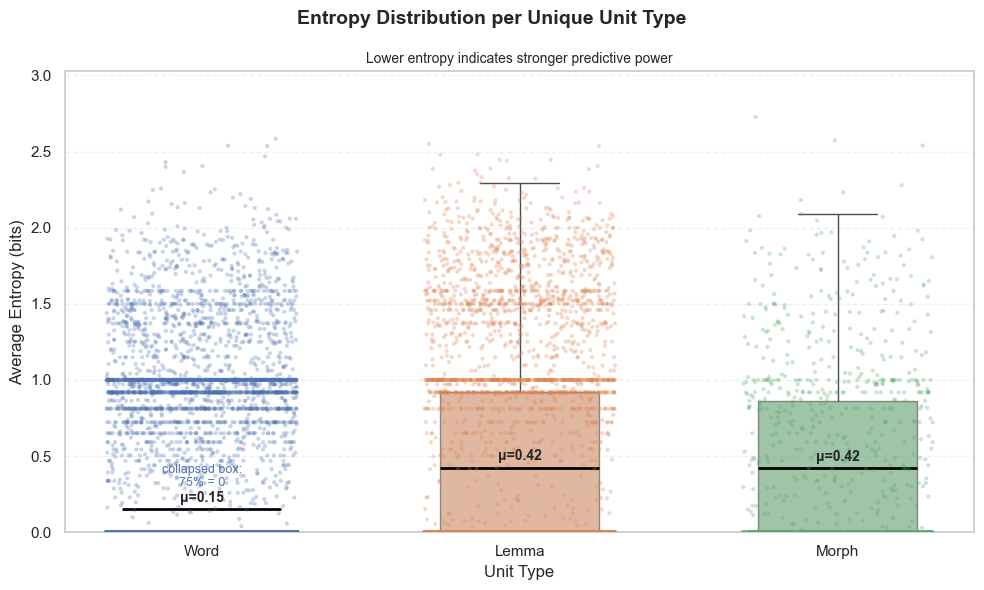

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create 'type' label if not already present
word_entropy['type'] = 'Word'
lemma_entropy['type'] = 'Lemma'
morph_entropy['type'] = 'Morph'

# Combine into one DataFrame
combined_df = pd.concat([word_entropy, lemma_entropy, morph_entropy], ignore_index=True)

# Calculate means and medians
means = combined_df.groupby('type')['avg_entropy'].mean()
medians = combined_df.groupby('type')['avg_entropy'].median()
iqrs = combined_df.groupby('type')['avg_entropy'].quantile(0.75) - combined_df.groupby('type')['avg_entropy'].quantile(0.25)

# Custom color palette
palette = {
    'Word': '#4C72B0',
    'Lemma': '#DD8452',
    'Morph': '#55A868'
}

# Plot setup
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Draw boxplot
sns.boxplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    palette=palette,
    width=0.5,
    fliersize=0,
    boxprops=dict(alpha=0.6)
)

# Draw stripplot (with hue for clarity)
sns.stripplot(
    data=combined_df,
    x='type',
    y='avg_entropy',
    hue='type',
    palette=palette,
    dodge=False,
    jitter=0.3,
    size=3,
    alpha=0.3,
    linewidth=0
)

# Add visible mean lines and annotations
for i, type_name in enumerate(['Word', 'Lemma', 'Morph']):
    mean_val = means[type_name]
    median_val = medians[type_name]
    iqr = iqrs[type_name]

    # Highlight mean
    plt.hlines(mean_val, i - 0.25, i + 0.25, color='black', linewidth=2)
    plt.text(i, mean_val + 0.05, f"μ={mean_val:.2f}", ha='center', fontsize=10, weight='bold')

    # Annotate if IQR is collapsed
    if iqr == 0:
        plt.text(i, mean_val + 0.15, "collapsed box:\n75% = 0", ha='center', fontsize=9, color=palette[type_name])

# Plot labels
plt.suptitle("Entropy Distribution per Unique Unit Type", fontsize=14, fontweight='bold')
plt.title("Lower entropy indicates stronger predictive power", fontsize=10)
plt.xlabel("Unit Type", fontsize=12)
plt.ylabel("Average Entropy (bits)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, combined_df['avg_entropy'].max() + 0.3)
plt.legend([], [], frameon=False)  # remove redundant legend
plt.tight_layout()
plt.show()


## Phrase- and Sentence-Level Z-Score Aggregation
Now we aggregate the entropy scores by phrase and sentence, and compute Z-scores to identify outliers at higher linguistic levels.

**Dit is mijn idee zodra het voorgaande is gefixed**

In [ ]:
# Simulate phrase and sentence IDs for aggregation
df['phrase_id'] = ['p1', 'p1', 'p2', 'p3', 'p3']
df['sentence_id'] = ['s1', 's1', 's1', 's1', 's1']

### Aggregate by Phrase

ik denk dat het volgende ook nog wel zou kunnen om aggreratie per group of words te berekenen...

In [2]:
df_phrase = df.groupby('phrase_id').agg(
    mean_text_ent=('text_ent', 'mean'),
    mean_lemma_ent=('lemma_ent', 'mean'),
    mean_morph_ent=('morph_ent', 'mean'),
    word_count=('word_id', 'count')
).reset_index()

# Compute z-scores for phrase-level mean entropies
df_phrase['z_text'] = (df_phrase['mean_text_ent'] - df_phrase['mean_text_ent'].mean()) / df_phrase['mean_text_ent'].std()
df_phrase['z_lemma'] = (df_phrase['mean_lemma_ent'] - df_phrase['mean_lemma_ent'].mean()) / df_phrase['mean_lemma_ent'].std()
df_phrase['z_morph'] = (df_phrase['mean_morph_ent'] - df_phrase['mean_morph_ent'].mean()) / df_phrase['mean_morph_ent'].std()
df_phrase

NameError: name 'df' is not defined

### Aggregate by Sentence

In [ ]:
df_sentence = df.groupby('sentence_id').agg(
    mean_text_ent=('text_ent', 'mean'),
    mean_lemma_ent=('lemma_ent', 'mean'),
    mean_morph_ent=('morph_ent', 'mean'),
    word_count=('word_id', 'count')
).reset_index()

# Compute z-scores for sentence-level mean entropies
df_sentence['z_text'] = (df_sentence['mean_text_ent'] - df_sentence['mean_text_ent'].mean()) / df_sentence['mean_text_ent'].std()
df_sentence['z_lemma'] = (df_sentence['mean_lemma_ent'] - df_sentence['mean_lemma_ent'].mean()) / df_sentence['mean_lemma_ent'].std()
df_sentence['z_morph'] = (df_sentence['mean_morph_ent'] - df_sentence['mean_morph_ent'].mean()) / df_sentence['mean_morph_ent'].std()
df_sentence